In [1]:
import os, sys
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import torch
import pandas as pd 

# 0. Prepare Data

### specify the directories used for running the code:
* `data_dir`: where raw dataset is loaded; raw data is in csv format
* `processed_data_dir`: where processed dataset is loaded; processed data is in npy pickle format
    * processed data should be a ndarray of shape (participants_num x sessions_num(3) x days_per_session(10)*trail_per_day(4) x #examples_window*#mov(26*22=572) x processed_channel_num(252))
    * for instance: processed examples have shape **(5, 3, 40, 572, 252)** and labels have shape **(5, 3, 40, 572)**
* `path_<model_name>`: where model weights are saved
    * weights should be saved in folder `/Weights/<model_name>`. Each folder has subfolders containing weights for each participant.
    * weights for TSD model contain 3 set of training model. weights for DANN and SCADANN contain 2 set of trianing model (these two models are trianed based on TSD, so they do not have a best_state_0.pt model. 
* `save_<model_name>`: where model results are saved
    * each result for testing a model on a group of datset is saved in folder `results`. Each result has corresponding 
        * `<model_name>.txt` includes predictions, ground truths, array of accuracies for each participant and each session, and overall accuracy
        * `predictions_<model_name>.npy` includes array of accuracies, ground truths, predictions, and model outputs (probability array for each prediction)
        * remember to make blank files in these names before saving

* use `read_data_training` to process raw dataset
        

In [2]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG_myo")
from PrepareAndLoadData.process_data import read_data_training

In [3]:
data_dir = "/home/laiy/gitrepos/msr_final/Wearable_Sensor_Long-term_sEMG_Dataset/data"
processed_data_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Processed_datasets"
code_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo"
save_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Results"

path_TSD ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights/TSD"
save_TSD = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_DANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights/DANN"
save_DANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_SCADANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights/SCADANN"
save_SCADANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

In [4]:
# read_data_training(path=data_dir, store_path = processed_data_dir, num_participant=5)

In [5]:
# check stored pickle 
with open(processed_data_dir + "/training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
print('traning examples ', np.shape(examples_datasets_train))
labels_datasets_train = dataset_training['labels_training']
print('traning labels ', np.shape(labels_datasets_train))

traning examples  (5, 3, 40, 572, 252)
traning labels  (5, 3, 40, 572)


### Specify params used for training and testing

During training and testing, processed datasets are first put into pytorch dataloders, then feed to the model trainer; following are params for TSD model and dataloaders

* `num_kernels`: list of integers defining number of neurons used in each layer of linear block (linear block has `dropout`=0.5)
* `number_of_cycles_total`: number of trails performed for each session (assuming that all session have the same trail size)
    * 40 for myo
* `number_of_classes`: total number of gestures performed in dataset
    * 22 for myo
* `batch_size`: number of examples stored in each batch
* `feature_vector_input_length`: length of input array or each processed signal 
    * 252 for myo
* `learning_rate`= 0.002515
    

In [6]:
num_kernels=[200, 200, 200]                        # model layer size 
number_of_cycles_total=np.shape(examples_datasets_train[0][0])[0]               # #session
print("number_of_cycles_total ", number_of_cycles_total)
number_of_classes=22
batch_size=128          
feature_vector_input_length=252                     # size of one example 
learning_rate=0.002515

number_of_cycles_total  40


# 1. TSD_DNN
* `train_fine_tuning`: used to train data using TSD network only   
    * running this function will save three sets of TSD model weights (each is fine tuned based on the previous training)  
    
* `test_TSD_DNN_on_training_sessions`: test model result


### check if dataloaders are loaded correctly:
* each participant has shape (session_num x 40 x 572 x 252)
* each session has shape (40 x 572 x 252)
* put these data into on group ends up with shape (40*572=22880, 252)
    * shuffle on group of data and put into dataloaders
    * each participant should have 3 sets of dataloaders, each correspond to one session

In [7]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_standard import \
            test_TSD_DNN_on_training_sessions, train_fine_tuning

In [8]:
train_fine_tuning(examples_datasets_train, labels_datasets_train,
                  num_kernels=num_kernels, path_weight_to_save_to=path_TSD,
                  number_of_classes=number_of_classes, number_of_cycles_total=number_of_cycles_total,
                  batch_size=batch_size,
                  feature_vector_input_length=feature_vector_input_length,
                  learning_rate=learning_rate)

GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 0)
GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (228

train Loss: 0.00476916 Acc: 0.79267578
val Loss: 0.00016620 Acc: 0.86582168
New best validation loss: 0.00016619933287163714
Epoch 1 of 500 took 1.060s
Epoch 1/499
----------
train Loss: 0.00362823 Acc: 0.83842773
val Loss: 0.00012942 Acc: 0.89379371
Epoch 2 of 500 took 1.071s
Epoch 2/499
----------
train Loss: 0.00323466 Acc: 0.85234375
val Loss: 0.00010131 Acc: 0.91608392
Epoch 3 of 500 took 1.073s
Epoch 3/499
----------
train Loss: 0.00287825 Acc: 0.86904297
val Loss: 0.00008440 Acc: 0.92963287
Epoch 4 of 500 took 1.055s
Epoch 4/499
----------
train Loss: 0.00276371 Acc: 0.87597656
val Loss: 0.00008892 Acc: 0.92438811
Epoch 5 of 500 took 1.140s
Epoch 5/499
----------
train Loss: 0.00257794 Acc: 0.88603516
val Loss: 0.00006963 Acc: 0.94274476
Epoch 6 of 500 took 1.166s
Epoch 6/499
----------
train Loss: 0.00245748 Acc: 0.88984375
val Loss: 0.00007189 Acc: 0.94361888
Epoch 7 of 500 took 1.140s
Epoch 7/499
----------
train Loss: 0.00238022 Acc: 0.89575195
val Loss: 0.00009058 Acc: 0.92

train Loss: 0.00274411 Acc: 0.88261719
val Loss: 0.00008894 Acc: 0.9256993
Epoch 2 of 500 took 1.115s
Epoch 2/499
----------
train Loss: 0.00224849 Acc: 0.90419922
val Loss: 0.00008232 Acc: 0.92744755
Epoch 3 of 500 took 1.028s
Epoch 3/499
----------
train Loss: 0.00199261 Acc: 0.9128418
val Loss: 0.00006193 Acc: 0.9527972
Epoch 4 of 500 took 1.041s
Epoch 4/499
----------
train Loss: 0.00182128 Acc: 0.91967773
val Loss: 0.00006655 Acc: 0.94536713
Epoch 5 of 500 took 1.034s
Epoch 5/499
----------
train Loss: 0.00168607 Acc: 0.92709961
val Loss: 0.00004382 Acc: 0.96765734
Epoch 6 of 500 took 1.053s
Epoch 6/499
----------
train Loss: 0.00161933 Acc: 0.93081055
val Loss: 0.00005441 Acc: 0.95498252
Epoch 7 of 500 took 1.075s
Epoch 7/499
----------
train Loss: 0.00149237 Acc: 0.93461914
val Loss: 0.00005282 Acc: 0.95236014
Epoch 8 of 500 took 1.050s
Epoch 8/499
----------
train Loss: 0.00147053 Acc: 0.93608398
val Loss: 0.00003693 Acc: 0.97071678
Epoch 9 of 500 took 1.057s
Epoch 9/499
------

train Loss: 0.00342655 Acc: 0.84458008
val Loss: 0.00010645 Acc: 0.9020979
New best validation loss: 0.00010645294470803721
Epoch 1 of 500 took 1.062s
Epoch 1/499
----------
train Loss: 0.00268143 Acc: 0.88027344
val Loss: 0.00008217 Acc: 0.9291958
Epoch 2 of 500 took 1.084s
Epoch 2/499
----------
train Loss: 0.00240718 Acc: 0.88657227
val Loss: 0.00007555 Acc: 0.93575175
Epoch 3 of 500 took 1.089s
Epoch 3/499
----------
train Loss: 0.00224069 Acc: 0.89375
val Loss: 0.00006679 Acc: 0.94055944
Epoch 4 of 500 took 1.072s
Epoch 4/499
----------
train Loss: 0.00207336 Acc: 0.90693359
val Loss: 0.00006252 Acc: 0.94449301
Epoch 5 of 500 took 1.048s
Epoch 5/499
----------
train Loss: 0.00197907 Acc: 0.90839844
val Loss: 0.00005702 Acc: 0.95236014
Epoch 6 of 500 took 1.079s
Epoch 6/499
----------
train Loss: 0.00187371 Acc: 0.91484375
val Loss: 0.00006332 Acc: 0.94493007
Epoch 7 of 500 took 1.070s
Epoch 7/499
----------
train Loss: 0.00177247 Acc: 0.92119141
val Loss: 0.00005442 Acc: 0.9519230

train Loss: 0.00575037 Acc: 0.70029297
val Loss: 0.00028220 Acc: 0.73688811
Epoch 2 of 500 took 1.156s
Epoch 2/499
----------
train Loss: 0.00536212 Acc: 0.72001953
val Loss: 0.00024884 Acc: 0.75743007
Epoch 3 of 500 took 1.082s
Epoch 3/499
----------
train Loss: 0.00516473 Acc: 0.72792969
val Loss: 0.00023565 Acc: 0.7770979
Epoch 4 of 500 took 1.201s
Epoch 4/499
----------
train Loss: 0.00499405 Acc: 0.73476562
val Loss: 0.00023044 Acc: 0.7701049
Epoch 5 of 500 took 1.148s
Epoch 5/499
----------
train Loss: 0.00486482 Acc: 0.74692383
val Loss: 0.00023632 Acc: 0.75743007
Epoch 6 of 500 took 1.071s
Epoch 6/499
----------
train Loss: 0.00473331 Acc: 0.75063477
val Loss: 0.00022760 Acc: 0.78190559
Epoch 7 of 500 took 1.153s
Epoch 7/499
----------
train Loss: 0.00465928 Acc: 0.75620117
val Loss: 0.00022471 Acc: 0.78671329
Epoch 8 of 500 took 1.172s
Epoch 8/499
----------
train Loss: 0.00457342 Acc: 0.75976562
val Loss: 0.00023045 Acc: 0.78321678
Epoch 9 of 500 took 1.123s
Epoch 9/499
-----

train Loss: 0.00555730 Acc: 0.75419922
val Loss: 0.00024017 Acc: 0.80594406
Epoch 3 of 500 took 1.273s
Epoch 3/499
----------
train Loss: 0.00525169 Acc: 0.76791992
val Loss: 0.00021651 Acc: 0.82473776
Epoch 4 of 500 took 1.236s
Epoch 4/499
----------
train Loss: 0.00500750 Acc: 0.77744141
val Loss: 0.00020598 Acc: 0.83304196
Epoch 5 of 500 took 1.095s
Epoch 5/499
----------
train Loss: 0.00481178 Acc: 0.78549805
val Loss: 0.00019242 Acc: 0.85314685
Epoch 6 of 500 took 1.081s
Epoch 6/499
----------
train Loss: 0.00458347 Acc: 0.79794922
val Loss: 0.00021009 Acc: 0.83216783
Epoch 7 of 500 took 1.104s
Epoch 7/499
----------
train Loss: 0.00449432 Acc: 0.80366211
val Loss: 0.00024100 Acc: 0.79414336
Epoch 8 of 500 took 1.093s
Epoch 8/499
----------
train Loss: 0.00439516 Acc: 0.80483398
val Loss: 0.00019633 Acc: 0.83085664
Epoch 9 of 500 took 1.088s
Epoch 9/499
----------
train Loss: 0.00427314 Acc: 0.81450195
val Loss: 0.00017872 Acc: 0.85926573
Epoch 10 of 500 took 1.049s
Epoch 10/499
-

train Loss: 0.00635396 Acc: 0.71079102
val Loss: 0.00025546 Acc: 0.78627622
New best validation loss: 0.00025545881240517944
Epoch 1 of 500 took 1.067s
Epoch 1/499
----------
train Loss: 0.00527693 Acc: 0.75507813
val Loss: 0.00023402 Acc: 0.81555944
Epoch 2 of 500 took 1.066s
Epoch 2/499
----------
train Loss: 0.00497173 Acc: 0.76894531
val Loss: 0.00022735 Acc: 0.80638112
Epoch 3 of 500 took 1.136s
Epoch 3/499
----------
train Loss: 0.00468638 Acc: 0.78339844
val Loss: 0.00020661 Acc: 0.82298951
Epoch 4 of 500 took 1.077s
Epoch 4/499
----------
train Loss: 0.00455639 Acc: 0.78925781
val Loss: 0.00020797 Acc: 0.8243007
Epoch 5 of 500 took 1.083s
Epoch 5/499
----------
train Loss: 0.00443152 Acc: 0.79829102
val Loss: 0.00018268 Acc: 0.84965035
Epoch 6 of 500 took 1.072s
Epoch 6/499
----------
train Loss: 0.00425387 Acc: 0.80439453
val Loss: 0.00017649 Acc: 0.84921329
Epoch 7 of 500 took 1.087s
Epoch 7/499
----------
train Loss: 0.00418945 Acc: 0.80629883
val Loss: 0.00019621 Acc: 0.829

train Loss: 0.00442462 Acc: 0.81064453
val Loss: 0.00016386 Acc: 0.85576923
New best validation loss: 0.00016386439646040642
Epoch 1 of 500 took 1.065s
Epoch 1/499
----------
train Loss: 0.00367355 Acc: 0.82978516
val Loss: 0.00013808 Acc: 0.89073427
Epoch 2 of 500 took 1.113s
Epoch 2/499
----------
train Loss: 0.00348580 Acc: 0.84248047
val Loss: 0.00013713 Acc: 0.8833042
Epoch 3 of 500 took 1.045s
Epoch 3/499
----------
train Loss: 0.00331671 Acc: 0.85151367
val Loss: 0.00014517 Acc: 0.87194056
Epoch 4 of 500 took 1.086s
Epoch 4/499
----------
train Loss: 0.00308542 Acc: 0.85966797
val Loss: 0.00011501 Acc: 0.89991259
Epoch 5 of 500 took 1.057s
Epoch 5/499
----------
train Loss: 0.00305516 Acc: 0.85913086
val Loss: 0.00012410 Acc: 0.88548951
Epoch 6 of 500 took 1.061s
Epoch 6/499
----------
train Loss: 0.00298981 Acc: 0.8637207
val Loss: 0.00012495 Acc: 0.8902972
Epoch 7 of 500 took 1.129s
Epoch 7/499
----------
train Loss: 0.00282509 Acc: 0.86865234
val Loss: 0.00011359 Acc: 0.89772

In [9]:
algo_name = "standard_TSD"
test_TSD_DNN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=num_kernels, use_only_first_training=True,
                                  path_weights=path_TSD,
                                  feature_vector_input_length=feature_vector_input_length,
                                  save_path = save_TSD, algo_name=algo_name,
                                  number_of_cycles_total=number_of_cycles_total,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0

Participant:  1  Accuracy:  0.9447552447552447
1  SESSION   data =  5720
Participant:  1  Accuracy:  0.7868881118881119
2  SESSION   data =  5720
Participant:  1  Accuracy:  0.8263986013986014
ACCURACY PARTICIPANT  1 :  [0.9447552447552447, 0.7868881118881119, 0.8263986013986014]
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=252, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
      )
      (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): 

In [10]:
results_filename = save_TSD + '/predictions_' + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
TSD_acc = results[0]
TSD_acc_overall = np.mean(TSD_acc)
TSD_df = pd.DataFrame(TSD_acc.transpose(), 
                       index = [f'Session_{i}' for i in range(TSD_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(TSD_acc.shape[0])])
TSD_df

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Session_0,0.870455,0.944755,0.728497,0.79021,0.893182
Session_1,0.692308,0.786888,0.622378,0.717483,0.697902
Session_2,0.587587,0.826399,0.539336,0.605944,0.59458


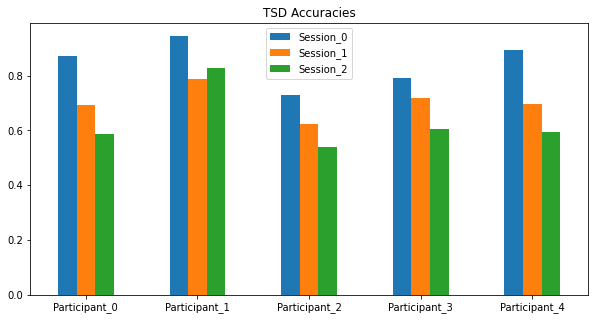

In [11]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.show()

# 2. DANN
* `train_DANN`: train DANN model using the first set of training weights from TSD model
    * two set of training weights will be saved
* `test_DANN_on_training_sessions`: test DANN model

In [12]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_DA import train_DANN, test_DANN_on_training_sessions

In [13]:
train_DANN(examples_datasets_train, labels_datasets_train, 
          num_kernels=num_kernels,
          path_weights_fine_tuning=path_TSD,
          number_of_classes=number_of_classes,
          number_of_cycles_total = number_of_cycles_total,
          batch_size=batch_size,
          feature_vector_input_length=feature_vector_input_length,
          path_weights_to_save_to=path_DANN, learning_rate=learning_rate)

GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 0)
GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (228

Accuracy source 0.884863, main loss classifier 0.231986, source classification loss 0.324288, loss domain distinction 0.184490, accuracy domain distinction 0.500000
VALIDATION Loss: 0.25205898 Acc: 0.90821678
Epoch     7: reducing learning rate of group 0 to 5.0300e-04.
Epoch 6 of 500 took 2.286s
Accuracy source 0.912988, main loss classifier 0.195884, source classification loss 0.256927, loss domain distinction 0.180454, accuracy domain distinction 0.500000
VALIDATION Loss: 0.21952055 Acc: 0.92438811
Epoch 7 of 500 took 2.320s
Accuracy source 0.917383, main loss classifier 0.185839, source classification loss 0.236949, loss domain distinction 0.179999, accuracy domain distinction 0.500000
VALIDATION Loss: 0.17321004 Acc: 0.94187063
New best validation loss:  0.1732100397348404
Epoch 8 of 500 took 2.287s
Accuracy source 0.921973, main loss classifier 0.179614, source classification loss 0.224569, loss domain distinction 0.179660, accuracy domain distinction 0.500000
VALIDATION Loss: 0.

Accuracy source 0.947705, main loss classifier 0.142237, source classification loss 0.151040, loss domain distinction 0.178068, accuracy domain distinction 0.500000
VALIDATION Loss: 0.13406220 Acc: 0.95454545
Epoch 39 of 500 took 2.335s
Accuracy source 0.947754, main loss classifier 0.141584, source classification loss 0.149569, loss domain distinction 0.178157, accuracy domain distinction 0.500000
VALIDATION Loss: 0.12067214 Acc: 0.95891608
Epoch 40 of 500 took 2.499s
Accuracy source 0.944971, main loss classifier 0.143470, source classification loss 0.153466, loss domain distinction 0.178386, accuracy domain distinction 0.500000
VALIDATION Loss: 0.11853842 Acc: 0.95979021
Training complete in 1m 36s
()
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0

Accuracy source 0.938379, main loss classifier 0.154658, source classification loss 0.176049, loss domain distinction 0.177572, accuracy domain distinction 0.500000
VALIDATION Loss: 0.16097273 Acc: 0.94711538
Epoch 20 of 500 took 2.292s
Accuracy source 0.939697, main loss classifier 0.155685, source classification loss 0.178039, loss domain distinction 0.177330, accuracy domain distinction 0.500000
VALIDATION Loss: 0.15241146 Acc: 0.94886364
Epoch 21 of 500 took 2.350s
Accuracy source 0.941064, main loss classifier 0.153395, source classification loss 0.173557, loss domain distinction 0.177760, accuracy domain distinction 0.500000
VALIDATION Loss: 0.16088751 Acc: 0.94187063
Epoch 22 of 500 took 2.407s
Accuracy source 0.941943, main loss classifier 0.151706, source classification loss 0.170102, loss domain distinction 0.177512, accuracy domain distinction 0.500000
VALIDATION Loss: 0.14538431 Acc: 0.94973776
Epoch 23 of 500 took 2.395s
Accuracy source 0.940771, main loss classifier 0.151

Accuracy source 0.861182, main loss classifier 0.272745, source classification loss 0.401283, loss domain distinction 0.194389, accuracy domain distinction 0.499365
VALIDATION Loss: 0.18715674 Acc: 0.92963287
New best validation loss:  0.18715673685073853
Epoch 1 of 500 took 2.360s
Accuracy source 0.893555, main loss classifier 0.222511, source classification loss 0.303704, loss domain distinction 0.185831, accuracy domain distinction 0.500000
VALIDATION Loss: 0.15771604 Acc: 0.93706294
New best validation loss:  0.1577160358428955
Epoch 2 of 500 took 2.324s
Accuracy source 0.904199, main loss classifier 0.208498, source classification loss 0.275724, loss domain distinction 0.186388, accuracy domain distinction 0.500000
VALIDATION Loss: 0.11289618 Acc: 0.96284965
New best validation loss:  0.11289618164300919
Epoch 3 of 500 took 2.333s
Accuracy source 0.914307, main loss classifier 0.193418, source classification loss 0.245934, loss domain distinction 0.186407, accuracy domain distinct

Accuracy source 0.963916, main loss classifier 0.120698, source classification loss 0.107891, loss domain distinction 0.178795, accuracy domain distinction 0.500000
VALIDATION Loss: 0.06603350 Acc: 0.97421329
Epoch 34 of 500 took 2.229s
Accuracy source 0.967139, main loss classifier 0.115004, source classification loss 0.096431, loss domain distinction 0.179061, accuracy domain distinction 0.500000
VALIDATION Loss: 0.10498694 Acc: 0.96678322
Epoch 35 of 500 took 2.332s
Accuracy source 0.964063, main loss classifier 0.117005, source classification loss 0.100452, loss domain distinction 0.179064, accuracy domain distinction 0.500000
VALIDATION Loss: 0.08717502 Acc: 0.96853147
Epoch 36 of 500 took 2.314s
Accuracy source 0.966797, main loss classifier 0.116587, source classification loss 0.099596, loss domain distinction 0.179042, accuracy domain distinction 0.500000
VALIDATION Loss: 0.08180386 Acc: 0.96809441
Epoch 37 of 500 took 2.319s
Accuracy source 0.966699, main loss classifier 0.117

Accuracy source 0.959668, main loss classifier 0.127724, source classification loss 0.121891, loss domain distinction 0.178726, accuracy domain distinction 0.500000
VALIDATION Loss: 0.07899242 Acc: 0.97115385
Epoch 14 of 500 took 2.343s
Accuracy source 0.961768, main loss classifier 0.125037, source classification loss 0.116457, loss domain distinction 0.178645, accuracy domain distinction 0.500000
VALIDATION Loss: 0.05864469 Acc: 0.98164336
New best validation loss:  0.05864468961954117
Epoch 15 of 500 took 2.321s
Accuracy source 0.960400, main loss classifier 0.124822, source classification loss 0.116132, loss domain distinction 0.178690, accuracy domain distinction 0.500000
VALIDATION Loss: 0.06662707 Acc: 0.97858392
Epoch 16 of 500 took 2.286s
Accuracy source 0.962109, main loss classifier 0.124055, source classification loss 0.114599, loss domain distinction 0.178500, accuracy domain distinction 0.500000
VALIDATION Loss: 0.05912898 Acc: 0.97945804
Epoch 17 of 500 took 2.298s
Accur

Accuracy source 0.748291, main loss classifier 0.366581, source classification loss 0.598439, loss domain distinction 0.181107, accuracy domain distinction 0.500000
VALIDATION Loss: 0.54695004 Acc: 0.77884615
New best validation loss:  0.5469500422477722
Epoch 7 of 500 took 2.587s
Accuracy source 0.753906, main loss classifier 0.360785, source classification loss 0.586977, loss domain distinction 0.180973, accuracy domain distinction 0.500000
VALIDATION Loss: 0.57861555 Acc: 0.76005245
Epoch 8 of 500 took 2.625s
Accuracy source 0.766455, main loss classifier 0.348223, source classification loss 0.562136, loss domain distinction 0.179945, accuracy domain distinction 0.500000
VALIDATION Loss: 0.53239107 Acc: 0.77534965
New best validation loss:  0.5323910713195801
Epoch 9 of 500 took 2.459s
Accuracy source 0.767969, main loss classifier 0.344811, source classification loss 0.555080, loss domain distinction 0.180442, accuracy domain distinction 0.500000
VALIDATION Loss: 0.54518259 Acc: 0.

Accuracy source 0.662842, main loss classifier 0.485391, source classification loss 0.827074, loss domain distinction 0.194290, accuracy domain distinction 0.499292
VALIDATION Loss: 0.81335831 Acc: 0.66477273
New best validation loss:  0.8133583068847656
Epoch 1 of 500 took 2.871s
Accuracy source 0.687109, main loss classifier 0.446543, source classification loss 0.752354, loss domain distinction 0.186522, accuracy domain distinction 0.500000
VALIDATION Loss: 0.76494163 Acc: 0.68575175
New best validation loss:  0.7649416327476501
Epoch 2 of 500 took 2.486s
Accuracy source 0.704639, main loss classifier 0.426959, source classification loss 0.713744, loss domain distinction 0.186380, accuracy domain distinction 0.500000
VALIDATION Loss: 0.66806555 Acc: 0.71590909
New best validation loss:  0.6680655479431152
Epoch 3 of 500 took 2.443s
Accuracy source 0.714160, main loss classifier 0.415505, source classification loss 0.691751, loss domain distinction 0.184759, accuracy domain distinctio

Accuracy source 0.712207, main loss classifier 0.486668, source classification loss 0.829862, loss domain distinction 0.197825, accuracy domain distinction 0.498828
VALIDATION Loss: 0.82144243 Acc: 0.71372378
New best validation loss:  0.8214424252510071
Epoch 1 of 500 took 2.317s
Accuracy source 0.748975, main loss classifier 0.434514, source classification loss 0.728761, loss domain distinction 0.185648, accuracy domain distinction 0.500000
VALIDATION Loss: 0.64959484 Acc: 0.75655594
New best validation loss:  0.6495948433876038
Epoch 2 of 500 took 2.502s
Accuracy source 0.765430, main loss classifier 0.410651, source classification loss 0.681378, loss domain distinction 0.185547, accuracy domain distinction 0.500000
VALIDATION Loss: 0.56586391 Acc: 0.79807692
New best validation loss:  0.5658639073371887
Epoch 3 of 500 took 2.371s
Accuracy source 0.769971, main loss classifier 0.399524, source classification loss 0.659576, loss domain distinction 0.185452, accuracy domain distinctio

Accuracy source 0.854199, main loss classifier 0.279844, source classification loss 0.426356, loss domain distinction 0.178595, accuracy domain distinction 0.500000
VALIDATION Loss: 0.38203508 Acc: 0.86013986
New best validation loss:  0.3820350766181946
Epoch 33 of 500 took 2.399s
Accuracy source 0.854834, main loss classifier 0.279389, source classification loss 0.425406, loss domain distinction 0.178663, accuracy domain distinction 0.500000
VALIDATION Loss: 0.39923534 Acc: 0.85314685
Epoch 34 of 500 took 2.372s
Accuracy source 0.854492, main loss classifier 0.276909, source classification loss 0.420396, loss domain distinction 0.178732, accuracy domain distinction 0.500000
VALIDATION Loss: 0.38953650 Acc: 0.85795455
Epoch 35 of 500 took 2.266s
Accuracy source 0.855176, main loss classifier 0.278325, source classification loss 0.423417, loss domain distinction 0.177853, accuracy domain distinction 0.500000
VALIDATION Loss: 0.41273323 Acc: 0.84921329
Epoch 36 of 500 took 2.321s
Accura

Accuracy source 0.779883, main loss classifier 0.393383, source classification loss 0.647444, loss domain distinction 0.184794, accuracy domain distinction 0.500000
VALIDATION Loss: 0.56859821 Acc: 0.79414336
Epoch 4 of 500 took 2.296s
Accuracy source 0.783740, main loss classifier 0.384908, source classification loss 0.630963, loss domain distinction 0.184391, accuracy domain distinction 0.500000
VALIDATION Loss: 0.71971363 Acc: 0.76223776
Epoch 5 of 500 took 2.321s
Accuracy source 0.792188, main loss classifier 0.375498, source classification loss 0.612699, loss domain distinction 0.183810, accuracy domain distinction 0.500000
VALIDATION Loss: 0.56858838 Acc: 0.8006993
Epoch     7: reducing learning rate of group 0 to 5.0300e-04.
Epoch 6 of 500 took 2.391s
Accuracy source 0.813232, main loss classifier 0.341100, source classification loss 0.547546, loss domain distinction 0.180510, accuracy domain distinction 0.500000
VALIDATION Loss: 0.45396951 Acc: 0.83828671
New best validation lo

Accuracy source 0.839893, main loss classifier 0.303422, source classification loss 0.463671, loss domain distinction 0.195510, accuracy domain distinction 0.499194
VALIDATION Loss: 0.32345551 Acc: 0.87194056
New best validation loss:  0.3234555125236511
Epoch 1 of 500 took 2.338s
Accuracy source 0.842578, main loss classifier 0.293550, source classification loss 0.447431, loss domain distinction 0.185068, accuracy domain distinction 0.500000
VALIDATION Loss: 0.35691571 Acc: 0.86451049
Epoch 2 of 500 took 2.279s
Accuracy source 0.845508, main loss classifier 0.290129, source classification loss 0.440860, loss domain distinction 0.185273, accuracy domain distinction 0.500000
VALIDATION Loss: 0.38061270 Acc: 0.85882867
Epoch 3 of 500 took 2.291s
Accuracy source 0.843896, main loss classifier 0.290567, source classification loss 0.442233, loss domain distinction 0.184513, accuracy domain distinction 0.500000
VALIDATION Loss: 0.36112577 Acc: 0.87368881
Epoch 4 of 500 took 2.336s
Accuracy s

Accuracy source 0.905518, main loss classifier 0.199178, source classification loss 0.265190, loss domain distinction 0.178335, accuracy domain distinction 0.500000
VALIDATION Loss: 0.25242156 Acc: 0.90428322
Epoch 33 of 500 took 2.354s
Accuracy source 0.903369, main loss classifier 0.201917, source classification loss 0.270574, loss domain distinction 0.178527, accuracy domain distinction 0.500000
VALIDATION Loss: 0.22662911 Acc: 0.9138986
New best validation loss:  0.2266291081905365
Epoch 34 of 500 took 2.265s
Accuracy source 0.903711, main loss classifier 0.202224, source classification loss 0.271250, loss domain distinction 0.178222, accuracy domain distinction 0.500000
VALIDATION Loss: 0.24926379 Acc: 0.90777972
Epoch 35 of 500 took 2.334s
Accuracy source 0.905078, main loss classifier 0.199426, source classification loss 0.265646, loss domain distinction 0.178249, accuracy domain distinction 0.500000
VALIDATION Loss: 0.25286558 Acc: 0.90603147
Epoch 36 of 500 took 2.344s
Accurac

Accuracy source 0.884131, main loss classifier 0.226281, source classification loss 0.318713, loss domain distinction 0.178495, accuracy domain distinction 0.500000
VALIDATION Loss: 0.32127687 Acc: 0.87805944
Epoch 11 of 500 took 2.379s
Accuracy source 0.889160, main loss classifier 0.224100, source classification loss 0.314198, loss domain distinction 0.178702, accuracy domain distinction 0.500000
VALIDATION Loss: 0.31397140 Acc: 0.88723776
Epoch    20: reducing learning rate of group 0 to 1.0060e-04.
Epoch 12 of 500 took 2.373s
Accuracy source 0.892920, main loss classifier 0.217060, source classification loss 0.300825, loss domain distinction 0.178272, accuracy domain distinction 0.500000
VALIDATION Loss: 0.25746673 Acc: 0.8986014
Epoch 13 of 500 took 2.335s
Accuracy source 0.895215, main loss classifier 0.215429, source classification loss 0.297790, loss domain distinction 0.177848, accuracy domain distinction 0.500000
VALIDATION Loss: 0.24341749 Acc: 0.91083916
New best validation

Accuracy source 0.906738, main loss classifier 0.197388, source classification loss 0.261612, loss domain distinction 0.177777, accuracy domain distinction 0.500000
VALIDATION Loss: 0.26745754 Acc: 0.89903846
Epoch 45 of 500 took 2.654s
Accuracy source 0.904297, main loss classifier 0.199307, source classification loss 0.265616, loss domain distinction 0.177388, accuracy domain distinction 0.500000
VALIDATION Loss: 0.30949166 Acc: 0.88548951
Epoch 46 of 500 took 2.540s
Accuracy source 0.906592, main loss classifier 0.195754, source classification loss 0.258401, loss domain distinction 0.177665, accuracy domain distinction 0.500000
VALIDATION Loss: 0.24591558 Acc: 0.90472028
Epoch 47 of 500 took 2.592s
Accuracy source 0.908057, main loss classifier 0.195934, source classification loss 0.258816, loss domain distinction 0.177380, accuracy domain distinction 0.500000
VALIDATION Loss: 0.27135256 Acc: 0.90253497
Epoch 48 of 500 took 2.378s
Accuracy source 0.910010, main loss classifier 0.193

In [14]:
algo_name = "DANN"
test_DANN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                              feature_vector_input_length=feature_vector_input_length,
                              num_neurons=num_kernels, path_weights_DA=path_DANN,
                              algo_name=algo_name, save_path = save_DANN, 
                              number_of_cycles_total=number_of_cycles_total,
                              path_weights_normal=path_TSD, number_of_classes=number_of_classes,
                              cycle_for_test=3)

GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0

Participant ID:  1  Session ID:  2  Accuracy:  0.8734265734265734
ACCURACY PARTICIPANT:  [0.9447552447552447, 0.8746503496503496, 0.8734265734265734]
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=252, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
      )
      (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): LinearBlocks(
      (fully_connected_1): Linear(in_features=200, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200,

In [15]:
results_filename = save_DANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
DANN_acc = results[0]
DANN_acc_overall = np.mean(DANN_acc)
DANN_df = pd.DataFrame(DANN_acc.transpose(), 
                       index = [f'Session_{i}' for i in range(DANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(DANN_acc.shape[0])])
DANN_df

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Session_0,0.870455,0.944755,0.728497,0.79021,0.893182
Session_1,0.704895,0.87465,0.684965,0.766783,0.730769
Session_2,0.712937,0.873427,0.60507,0.684441,0.587063


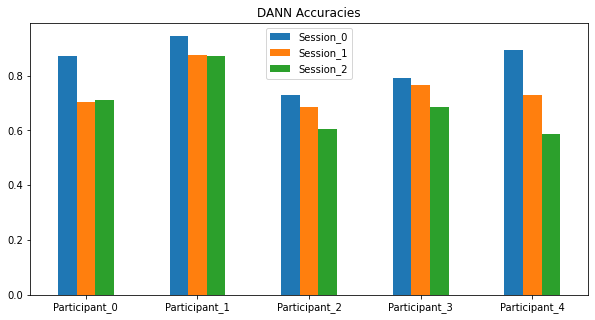

In [16]:
DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("DANN Accuracies")
plt.show()

# 3. SCADANN
* `run_SCADANN_training_sessions`: train SCADANN model. The first session uses TSD model_0 wegits; others use DANN weights
    * specify `percentage_same_gesture_stable` based on the performance of most pseudo labels 
        * print accuracies out and check what percentage will optimize `ACCURACY MODEL` and `ACCURACY PSEUDO` without cutting out too much data 
    * two set of training weights will be saved
* `test_network_SLADANN`: test DANN model

In [17]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_SCADANN import run_SCADANN_training_sessions, test_network_SLADANN

In [18]:
percentage_same_gesture_stable = 0.75 
run_SCADANN_training_sessions(examples_datasets=examples_datasets_train, labels_datasets=labels_datasets_train,
                              num_kernels=num_kernels, feature_vector_input_length=feature_vector_input_length,
                              path_weights_to_save_to=path_SCADANN,
                              path_weights_Adversarial_training=path_DANN,
                              path_weights_Normal_training=path_TSD,
                              number_of_cycles_total = number_of_cycles_total, 
                              number_of_classes=number_of_classes,
                              learning_rate=learning_rate)

GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (22880, 252)    (22880,)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (22880, 252)    (22880,)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (22880, 252)    (22880,)
dataloaders: 
   train  (1, 3)
   valid  (0,)
   test  (1, 0)
GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (22880, 252)    (22880,)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT o

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  2
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  0.5384615384615384  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.6111111111111112  len before:  26   len after:  18
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  11
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  14
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:

/home/laiy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/laiy/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 0.07692307692307693   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.4230769230769231   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.5384615384615384   AFTER:  0.6470588235294118  len before:  26   len after:  17
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  26
B

BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.38461538461538464  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  0.23076923076923078  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  0.5769230769230769  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.5769230769230769   AFTER:  0.461538461538

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  3
BEFORE:  0.5   AFTER:  0.46153846153846156  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.38461538461538464  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.15384615384615385  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.38461538461538464  len bef

Accuracy total 0.896863, main loss classifier 0.435488, source accuracy 0.931807 source classification loss 0.199542, target accuracy 0.861919 target loss 0.466403 accuracy domain distinction 0.500000 loss domain distinction 1.025156,
VALIDATION Loss: 0.32800997 Acc: 0.89666021
Epoch 7 of 500 took 3.661s
Accuracy total 0.898438, main loss classifier 0.428761, source accuracy 0.933140 source classification loss 0.192682, target accuracy 0.863735 target loss 0.459758 accuracy domain distinction 0.500000 loss domain distinction 1.025408,
VALIDATION Loss: 0.25891369 Acc: 0.91674734
New best validation loss:  0.2589136922588715
Epoch 8 of 500 took 3.595s
Accuracy total 0.898498, main loss classifier 0.435733, source accuracy 0.933442 source classification loss 0.197679, target accuracy 0.863554 target loss 0.468748 accuracy domain distinction 0.500000 loss domain distinction 1.025199,
VALIDATION Loss: 0.36072330 Acc: 0.89060987
Epoch 9 of 500 took 3.427s
Accuracy total 0.900133, main loss c

HANDLING NEW SESSION  1
Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  2
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  0.5384615384615384  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.6111111111111112  len before:  26   len after:  18
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  11
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  14
BEFORE:  0.9615384615384616   AFTER:  1.0  len 

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  1.0  len before:  26   len after:  9
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  1
BEFORE:  0.0   AFTER:  0.0  len before:  

BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.2692307692307692  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:

BEFORE:  0.46153846153846156   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.38461538461538464   AFTER:  0.07692307692307693  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.15384615384615385  len before:  26   len after:  13
BEFORE:  0.2692307692307692   AFTER:  

BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.4230769230769231   AFTER:  0.4230769230769231  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.11538461538461539  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.8846153846153846

STARTING TRAINING
Accuracy total 0.851121, main loss classifier 0.614925, source accuracy 0.879977 source classification loss 0.410974, target accuracy 0.822266 target loss 0.610946 accuracy domain distinction 0.500000 loss domain distinction 1.039651,
VALIDATION Loss: 0.42665129 Acc: 0.87257618
New best validation loss:  0.4266512907213635
Epoch 2 of 500 took 3.508s
Accuracy total 0.857579, main loss classifier 0.560769, source accuracy 0.888735 source classification loss 0.366749, target accuracy 0.826424 target loss 0.549675 accuracy domain distinction 0.500000 loss domain distinction 1.025570,
VALIDATION Loss: 0.43974330 Acc: 0.87761269
Epoch 3 of 500 took 3.347s
Accuracy total 0.860257, main loss classifier 0.553683, source accuracy 0.883569 source classification loss 0.369887, target accuracy 0.836946 target loss 0.532680 accuracy domain distinction 0.500000 loss domain distinction 1.023997,
VALIDATION Loss: 0.34254734 Acc: 0.89095946
New best validation loss:  0.3425473406437843

Accuracy total 0.878308, main loss classifier 0.467231, source accuracy 0.895980 source classification loss 0.312557, target accuracy 0.860635 target loss 0.417251 accuracy domain distinction 0.500000 loss domain distinction 1.023274,
VALIDATION Loss: 0.37611643 Acc: 0.87660539
Epoch 28 of 500 took 3.341s
Training complete in 1m 34s
['participant_0']
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=252, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
      )
 

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  11
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.6538461538461539   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.46153846153846156  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  11
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before: 

STARTING TRAINING
Accuracy total 0.924091, main loss classifier 0.351649, source accuracy 0.955739 source classification loss 0.128647, target accuracy 0.892443 target loss 0.366549 accuracy domain distinction 0.500000 loss domain distinction 1.040509,
VALIDATION Loss: 0.17578205 Acc: 0.9462585
New best validation loss:  0.17578205126135246
Epoch 2 of 500 took 3.699s
Accuracy total 0.929886, main loss classifier 0.331249, source accuracy 0.956705 source classification loss 0.130590, target accuracy 0.903068 target loss 0.326462 accuracy domain distinction 0.500000 loss domain distinction 1.027230,
VALIDATION Loss: 0.19471989 Acc: 0.94172336
Epoch 3 of 500 took 3.694s
Accuracy total 0.930170, main loss classifier 0.321718, source accuracy 0.953920 source classification loss 0.136152, target accuracy 0.906420 target loss 0.302015 accuracy domain distinction 0.500000 loss domain distinction 1.026350,
VALIDATION Loss: 0.18661650 Acc: 0.93968254
Epoch 4 of 500 took 3.718s
Accuracy total 0.9

Accuracy total 0.942244, main loss classifier 0.275486, source accuracy 0.960000 source classification loss 0.117851, target accuracy 0.924489 target loss 0.227956 accuracy domain distinction 0.500000 loss domain distinction 1.025825,
VALIDATION Loss: 0.16816470 Acc: 0.94013605
Epoch 28 of 500 took 3.643s
Accuracy total 0.942642, main loss classifier 0.275503, source accuracy 0.958977 source classification loss 0.120212, target accuracy 0.926307 target loss 0.225641 accuracy domain distinction 0.500000 loss domain distinction 1.025764,
VALIDATION Loss: 0.15961243 Acc: 0.94399093
Epoch 29 of 500 took 3.587s
Accuracy total 0.942415, main loss classifier 0.274437, source accuracy 0.959830 source classification loss 0.120526, target accuracy 0.925000 target loss 0.223278 accuracy domain distinction 0.500000 loss domain distinction 1.025355,
VALIDATION Loss: 0.14746537 Acc: 0.95079365
Epoch    29: reducing learning rate of group 0 to 2.0120e-05.
Epoch 30 of 500 took 3.599s
Accuracy total 0.

HANDLING NEW SESSION  1
Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  0.8076923076923077  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.38461538461538464  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  0.46153846153846156  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  12
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.5769230769230769  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  2

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  0.5384615384615384  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.6153846153846154  len before:  2

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.80769230769230

STARTING TRAINING
Accuracy total 0.904109, main loss classifier 0.407391, source accuracy 0.918750 source classification loss 0.259684, target accuracy 0.889468 target loss 0.346926 accuracy domain distinction 0.500000 loss domain distinction 1.040862,
VALIDATION Loss: 0.16522849 Acc: 0.93919075
New best validation loss:  0.16522848786895766
Epoch 2 of 500 took 3.526s
Accuracy total 0.907407, main loss classifier 0.386955, source accuracy 0.921181 source classification loss 0.245212, target accuracy 0.893634 target loss 0.323368 accuracy domain distinction 0.500000 loss domain distinction 1.026643,
VALIDATION Loss: 0.18784206 Acc: 0.92947977
Epoch 3 of 500 took 3.581s
Accuracy total 0.913773, main loss classifier 0.371225, source accuracy 0.924942 source classification loss 0.235354, target accuracy 0.902604 target loss 0.301829 accuracy domain distinction 0.500000 loss domain distinction 1.026330,
VALIDATION Loss: 0.18315676 Acc: 0.94196532
Epoch 4 of 500 took 3.543s
Accuracy total 0.

Accuracy total 0.925637, main loss classifier 0.325342, source accuracy 0.933160 source classification loss 0.197881, target accuracy 0.918113 target loss 0.247987 accuracy domain distinction 0.500000 loss domain distinction 1.024078,
VALIDATION Loss: 0.16162602 Acc: 0.94219653
Epoch    27: reducing learning rate of group 0 to 4.0240e-06.
Epoch 28 of 500 took 3.558s
Accuracy total 0.923351, main loss classifier 0.328360, source accuracy 0.930035 source classification loss 0.206764, target accuracy 0.916667 target loss 0.245202 accuracy domain distinction 0.500000 loss domain distinction 1.023767,
VALIDATION Loss: 0.15613144 Acc: 0.94289017
Epoch 29 of 500 took 3.628s
Accuracy total 0.925984, main loss classifier 0.323237, source accuracy 0.935648 source classification loss 0.196058, target accuracy 0.916319 target loss 0.245744 accuracy domain distinction 0.500000 loss domain distinction 1.023358,
VALIDATION Loss: 0.16378084 Acc: 0.94080925
Epoch 30 of 500 took 3.625s
Accuracy total 0.

HANDLING NEW SESSION  1
Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.0  len before:  26   len after:  3
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  8
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  13
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  1.0  len before:  26   len after:  3
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFOR

BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  0.8076923076923077  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  4
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  8
BEFORE:  0.46153846153846156   AFTER:  0.5769230769230769  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.0  len before:  26   len after:  11
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  16
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26  

BEFORE:  0.5384615384615384   AFTER:  0.5714285714285714  len before:  26   len after:  7
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after

STARTING TRAINING
Accuracy total 0.812165, main loss classifier 0.626452, source accuracy 0.772098 source classification loss 0.542128, target accuracy 0.852232 target loss 0.501623 accuracy domain distinction 0.500000 loss domain distinction 1.045761,
VALIDATION Loss: 0.28857458 Acc: 0.92426492
New best validation loss:  0.2885745814386404
Epoch 2 of 500 took 2.752s
Accuracy total 0.820089, main loss classifier 0.601891, source accuracy 0.773661 source classification loss 0.542197, target accuracy 0.866518 target loss 0.456262 accuracy domain distinction 0.500000 loss domain distinction 1.026620,
VALIDATION Loss: 0.31803783 Acc: 0.9046629
Epoch 3 of 500 took 2.982s
Accuracy total 0.821354, main loss classifier 0.593039, source accuracy 0.775223 source classification loss 0.541193, target accuracy 0.867485 target loss 0.439691 accuracy domain distinction 0.500000 loss domain distinction 1.025965,
VALIDATION Loss: 0.29579395 Acc: 0.91921592
Epoch 4 of 500 took 2.835s
Accuracy total 0.81

Accuracy total 0.831957, main loss classifier 0.563749, source accuracy 0.776711 source classification loss 0.541087, target accuracy 0.887202 target loss 0.381841 accuracy domain distinction 0.500000 loss domain distinction 1.022849,
VALIDATION Loss: 0.26756243 Acc: 0.91683992
Epoch    27: reducing learning rate of group 0 to 8.0480e-07.
Epoch 28 of 500 took 2.739s
Accuracy total 0.836421, main loss classifier 0.553928, source accuracy 0.781994 source classification loss 0.524368, target accuracy 0.890848 target loss 0.379082 accuracy domain distinction 0.500000 loss domain distinction 1.022026,
VALIDATION Loss: 0.25353472 Acc: 0.92545293
Epoch 29 of 500 took 2.731s
Accuracy total 0.832552, main loss classifier 0.560046, source accuracy 0.780580 source classification loss 0.533937, target accuracy 0.884524 target loss 0.381582 accuracy domain distinction 0.500000 loss domain distinction 1.022873,
VALIDATION Loss: 0.29534959 Acc: 0.91208791
Epoch 30 of 500 took 2.880s
Accuracy total 0.

HANDLING NEW SESSION  1
Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.0  len before:  26   len after:  3
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  8
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  13
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  1.0  len before:  26   len after:  3
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFOR

BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  13
BEFORE:  0.38461538461538464   AFTER:  0.14285714285714285  len before:  26   len after:  7
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  6
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.6923076923076923   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.5384615384615384   AFTER:  0.46153846153846156  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  0.8076923076923077   AFTER:  0.8076923076923077 

BEFORE:  0.38461538461538464   AFTER:  0.3076923076923077  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.46153846153846156   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.3076923076923077   AFTER:  0.3076923076923077  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  6
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.7692307692307693 

BEFORE:  0.6538461538461539   AFTER:  0.6538461538461539  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  3
BEFORE:  0.38461538461538464   AFTER:  0.38461538461538464  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  8
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  2

Finish segment dataset
Finish pseudo_labels
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  15
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  14
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2

BEFORE:  0.2692307692307692   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  4
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  3
BEFORE:  0.19230769230769232   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  0.6538461538461539   AFTER:  0.6538461538461539  len before:  26   len after:  26
BEFORE:  0.15384615384615385   

BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.38461538461538464   AFTER:  0.6923076923076923  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  14
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.6153846153846154   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.16666666666666666  len before:  26   len af

BEFORE:  0.2692307692307692   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.5384615384615384   AFTER:  0.7307692307692307  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.6923076923076923   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  15
BEFORE:  0.5769230769230769   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  0.4230769230769231  len before:  26   len after:  26


Accuracy total 0.823661, main loss classifier 0.633502, source accuracy 0.808637 source classification loss 0.516863, target accuracy 0.838685 target loss 0.545275 accuracy domain distinction 0.500000 loss domain distinction 1.024326,
VALIDATION Loss: 0.42258287 Acc: 0.87354352
Epoch 9 of 500 took 2.480s
Accuracy total 0.821815, main loss classifier 0.634370, source accuracy 0.802541 source classification loss 0.527968, target accuracy 0.841089 target loss 0.536020 accuracy domain distinction 0.500000 loss domain distinction 1.023761,
VALIDATION Loss: 0.45369802 Acc: 0.87183002
Epoch 10 of 500 took 2.455s
Accuracy total 0.825335, main loss classifier 0.629491, source accuracy 0.809667 source classification loss 0.522042, target accuracy 0.841003 target loss 0.532163 accuracy domain distinction 0.500000 loss domain distinction 1.023884,
VALIDATION Loss: 0.39146611 Acc: 0.89102125
New best validation loss:  0.3914661112686862
Epoch 11 of 500 took 2.438s
Accuracy total 0.826537, main loss

Accuracy total 0.833190, main loss classifier 0.597819, source accuracy 0.813874 source classification loss 0.504293, target accuracy 0.852507 target loss 0.486880 accuracy domain distinction 0.500000 loss domain distinction 1.022323,
VALIDATION Loss: 0.39465904 Acc: 0.88588074
Epoch 35 of 500 took 2.677s
Training complete in 1m 27s
['participant_1', 'participant_2', 'participant_0']
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=252, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropo

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  16
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.4230769230769231  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  14
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  9
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.4230769230769231  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8

BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.3076923076923077   AFTER:  0.8  len before:  26   len after:  5
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.6153846153846154   AFTER:  0.25  len before:  26   len after:  8
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  0.8461538461538461  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  11
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.9230769230769231   AFTER:  1.0 

BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  0.7307692307692307  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  

Accuracy total 0.856433, main loss classifier 0.532900, source accuracy 0.846430 source classification loss 0.444698, target accuracy 0.866436 target loss 0.416223 accuracy domain distinction 0.500000 loss domain distinction 1.024398,
VALIDATION Loss: 0.29100706 Acc: 0.90738325
Epoch 17 of 500 took 3.251s
Accuracy total 0.856891, main loss classifier 0.532777, source accuracy 0.847542 source classification loss 0.445447, target accuracy 0.866240 target loss 0.415333 accuracy domain distinction 0.500000 loss domain distinction 1.023867,
VALIDATION Loss: 0.26240628 Acc: 0.92094965
New best validation loss:  0.2624062774082025
Epoch 18 of 500 took 3.278s
Accuracy total 0.861304, main loss classifier 0.522920, source accuracy 0.849895 source classification loss 0.438324, target accuracy 0.872712 target loss 0.402531 accuracy domain distinction 0.500000 loss domain distinction 1.024927,
VALIDATION Loss: 0.30318490 Acc: 0.89799113
Epoch 19 of 500 took 3.552s
Accuracy total 0.859244, main los

HANDLING NEW SESSION  1
Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  16
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.4230769230769231  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  14
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.8846153846153846   AFTER:  1.0  len be

BEFORE:  0.6923076923076923   AFTER:  0.7692307692307693  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.6538461538461539  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  0.8888888888888888  len before:  26   len after:  9
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   

BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  1.0  len before:  26   len after:  1
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.

BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  3
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.46153846153846156   AFTER:  1.0  len before:  26   len after:  6
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  8
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.6538461538461539   AFTER:  0.6538461538461539  len before:  26

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  0.6923076923076923  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  12
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  13
BEFORE:  0.38461538461538464   AFTER:  1.0  len before:  26   len after:  4
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.4230769230769231   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.884615384615384

BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  0.5384615384615384  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  0.5  len before:  26   len after:  10
BEFORE:  0.46153846153846156   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.0  len before: 

BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  3
BEFORE:  0.19230769230769232   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.4230769230769231   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.7307692307692307   AFTER:  0.7307692307692307  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.0   AFTER:  0.0  len

STARTING TRAINING
Accuracy total 0.811128, main loss classifier 0.698723, source accuracy 0.826436 source classification loss 0.515171, target accuracy 0.795819 target loss 0.672563 accuracy domain distinction 0.500000 loss domain distinction 1.048566,
VALIDATION Loss: 0.44956173 Acc: 0.86363636
New best validation loss:  0.44956172576972414
Epoch 2 of 500 took 3.004s
Accuracy total 0.819468, main loss classifier 0.660805, source accuracy 0.831363 source classification loss 0.512140, target accuracy 0.807573 target loss 0.603986 accuracy domain distinction 0.500000 loss domain distinction 1.027423,
VALIDATION Loss: 0.42014360 Acc: 0.87317621
New best validation loss:  0.42014360214982716
Epoch 3 of 500 took 2.917s
Accuracy total 0.823691, main loss classifier 0.642715, source accuracy 0.833544 source classification loss 0.493634, target accuracy 0.813837 target loss 0.586797 accuracy domain distinction 0.500000 loss domain distinction 1.024995,
VALIDATION Loss: 0.42351850 Acc: 0.866722

Accuracy total 0.840055, main loss classifier 0.586612, source accuracy 0.842835 source classification loss 0.470526, target accuracy 0.837275 target loss 0.498164 accuracy domain distinction 0.500000 loss domain distinction 1.022671,
VALIDATION Loss: 0.42030417 Acc: 0.86223345
Epoch 28 of 500 took 2.909s
Accuracy total 0.843011, main loss classifier 0.582212, source accuracy 0.847128 source classification loss 0.466409, target accuracy 0.838894 target loss 0.493437 accuracy domain distinction 0.500000 loss domain distinction 1.022889,
VALIDATION Loss: 0.38817499 Acc: 0.87401796
Epoch 29 of 500 took 2.908s
Accuracy total 0.838858, main loss classifier 0.588932, source accuracy 0.840372 source classification loss 0.478646, target accuracy 0.837345 target loss 0.494692 accuracy domain distinction 0.500000 loss domain distinction 1.022629,
VALIDATION Loss: 0.36815636 Acc: 0.88945006
Epoch 30 of 500 took 2.912s
Accuracy total 0.842870, main loss classifier 0.579397, source accuracy 0.84677

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.6923076923076923  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  8
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  6
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  2

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.5   AFTER:  0.5714285714285714  len before:  26   len after:  7
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  16
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  1.0  len before:  26   len after:  12
BEFORE:  0.5   AFTER:  1.0  len before:  2

BEFORE:  0.38461538461538464   AFTER:  0.5769230769230769  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  0.7307692307692307  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.5882352941176471  len before:  26   len after:  17
BEFORE:  0.46153846153846156   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  

STARTING TRAINING
Accuracy total 0.856171, main loss classifier 0.565474, source accuracy 0.891052 source classification loss 0.311926, target accuracy 0.821289 target loss 0.610548 accuracy domain distinction 0.500000 loss domain distinction 1.042369,
VALIDATION Loss: 0.35179810 Acc: 0.88826543
New best validation loss:  0.35179810042564685
Epoch 2 of 500 took 3.351s
Accuracy total 0.859619, main loss classifier 0.543460, source accuracy 0.888306 source classification loss 0.316749, target accuracy 0.830933 target loss 0.564875 accuracy domain distinction 0.500000 loss domain distinction 1.026474,
VALIDATION Loss: 0.42986145 Acc: 0.86313735
Epoch 3 of 500 took 3.351s
Accuracy total 0.864014, main loss classifier 0.522775, source accuracy 0.890137 source classification loss 0.314142, target accuracy 0.837891 target loss 0.526353 accuracy domain distinction 0.500000 loss domain distinction 1.025271,
VALIDATION Loss: 0.35401612 Acc: 0.88558185
Epoch 4 of 500 took 3.381s
Accuracy total 0.

Accuracy total 0.879425, main loss classifier 0.463671, source accuracy 0.895691 source classification loss 0.300022, target accuracy 0.863159 target loss 0.422699 accuracy domain distinction 0.500000 loss domain distinction 1.023107,
VALIDATION Loss: 0.33264444 Acc: 0.8865577
Epoch 28 of 500 took 3.489s
Training complete in 1m 41s
['participant_1', 'participant_4', 'participant_2', 'participant_3', 'participant_0']
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=252, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1,

HANDLING NEW SESSION  1
Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.6923076923076923  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  8
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  6
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.8076923076923077   AFTER:  1.0  len bef

BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.25  len before:  26   len after:  4
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  0.8461538461538461  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  14
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  2

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.38461538461538464  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.615384615384

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  9
BEFORE:  0.5   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.6666666666666666  len before:  26   len after:  3
BEFORE:  0.4230769230769231   AFTER:  0.46153846153846156  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.6538461538461539   AFTER:  0.8076923076923077  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.9230769230769231  len before:  26   len after:  26
BEFORE:  0.538

BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  16
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  0.615384615

BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  4
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  0.

BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  0.2692307692307692  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  16
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  15
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE: 

Accuracy total 0.852382, main loss classifier 0.551706, source accuracy 0.868133 source classification loss 0.393435, target accuracy 0.836631 target loss 0.505614 accuracy domain distinction 0.500000 loss domain distinction 1.021822,
VALIDATION Loss: 0.37643116 Acc: 0.87635356
Epoch 21 of 500 took 3.479s
Accuracy total 0.854587, main loss classifier 0.546122, source accuracy 0.868952 source classification loss 0.396265, target accuracy 0.840222 target loss 0.491365 accuracy domain distinction 0.500000 loss domain distinction 1.023072,
VALIDATION Loss: 0.32623181 Acc: 0.88718207
New best validation loss:  0.3262318052233212
Epoch 22 of 500 took 3.377s
Accuracy total 0.853516, main loss classifier 0.544863, source accuracy 0.867314 source classification loss 0.391527, target accuracy 0.839718 target loss 0.493577 accuracy domain distinction 0.500000 loss domain distinction 1.023111,
VALIDATION Loss: 0.37281987 Acc: 0.87030975
Epoch 23 of 500 took 3.528s
Accuracy total 0.852571, main los

Accuracy total 0.856130, main loss classifier 0.541190, source accuracy 0.870275 source classification loss 0.387674, target accuracy 0.841986 target loss 0.490262 accuracy domain distinction 0.500000 loss domain distinction 1.022221,
VALIDATION Loss: 0.37978512 Acc: 0.87030975
Epoch 47 of 500 took 3.382s
Accuracy total 0.853736, main loss classifier 0.552061, source accuracy 0.866242 source classification loss 0.405357, target accuracy 0.841230 target loss 0.494376 accuracy domain distinction 0.500000 loss domain distinction 1.021950,
VALIDATION Loss: 0.37857885 Acc: 0.87559809
Epoch 48 of 500 took 3.648s
Accuracy total 0.855406, main loss classifier 0.540673, source accuracy 0.868637 source classification loss 0.393975, target accuracy 0.842175 target loss 0.482915 accuracy domain distinction 0.500000 loss domain distinction 1.022276,
VALIDATION Loss: 0.34367780 Acc: 0.88818937
Epoch    48: reducing learning rate of group 0 to 1.6096e-07.
Epoch 49 of 500 took 3.477s
Accuracy total 0.

In [19]:
algo_name = "SCADANN"
test_network_SLADANN(examples_datasets_train=examples_datasets_train, labels_datasets_train=labels_datasets_train,
                     num_neurons=num_kernels, feature_vector_input_length=feature_vector_input_length,
                     path_weights_SCADANN =path_SCADANN, path_weights_normal=path_TSD,
                     algo_name=algo_name, cycle_test=3, number_of_cycles_total=number_of_cycles_total,
                     number_of_classes=number_of_classes, save_path = save_SCADANN)

GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0

Participant:  1  Accuracy:  0.9447552447552447
Participant:  1  Accuracy:  0.9106643356643357
Participant:  1  Accuracy:  0.8903846153846153
ACCURACY PARTICIPANT:  [0.9447552447552447, 0.9106643356643357, 0.8903846153846153]
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=252, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
      )
      (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): LinearBlocks(
      (fully_connected_1): Linear(in_featu

In [20]:
results_filename = save_SCADANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
SCADANN_acc = results[0]
SCADANN_acc_overall = np.mean(SCADANN_acc)
SCADANN_df = pd.DataFrame(SCADANN_acc.transpose(), 
                       index = [f'Session_{i}' for i in range(SCADANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(SCADANN_acc.shape[0])])
SCADANN_df

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Session_0,0.870455,0.944755,0.728497,0.79021,0.893182
Session_1,0.733392,0.910664,0.688287,0.795629,0.765035
Session_2,0.754545,0.890385,0.618007,0.722552,0.61049


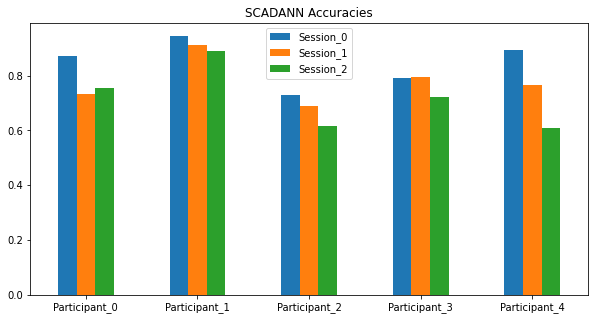

In [21]:
SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("SCADANN Accuracies")
plt.show()

# Conclusion
In general, overall accuracies of SCADANN is better than DANN, and DANN is better than TSD.   

Occasionally accuracies of SCADANN ends up a little smaller than DANN, reasons may be lack of datasets put into training model (fixed) and non-optimal percentage_same_gesture_sable (fixed). Code should be reproducable if processed dataset stick to the shape defined above.

* What to check if sth goes wrong:
    * percentage_same_gesture_sable
    * number of cycles or sessions
    * shape of dataloaders (combination of train, test, valid should include all dataset)
    * shape of procssed datasets
    * directory paths of weights and results
    * if weights are stored or loaded correclty

In [22]:
print("TSD")
display(TSD_df)
print("DANN")
display(DANN_df)
print("SCADANN")
display(SCADANN_df)

TSD


,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Session_0,0.870455,0.944755,0.728497,0.79021,0.893182
Session_1,0.692308,0.786888,0.622378,0.717483,0.697902
Session_2,0.587587,0.826399,0.539336,0.605944,0.59458


DANN


,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Session_0,0.870455,0.944755,0.728497,0.79021,0.893182
Session_1,0.704895,0.87465,0.684965,0.766783,0.730769
Session_2,0.712937,0.873427,0.60507,0.684441,0.587063


SCADANN


,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Session_0,0.870455,0.944755,0.728497,0.79021,0.893182
Session_1,0.733392,0.910664,0.688287,0.795629,0.765035
Session_2,0.754545,0.890385,0.618007,0.722552,0.61049


In [23]:
overall_acc_df = pd.DataFrame([TSD_acc_overall, DANN_acc_overall, SCADANN_acc_overall],
                             index = ["TSD", "DANN", "SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

,Overall_Acc
TSD,0.726527
DANN,0.763473
SCADANN,0.781072


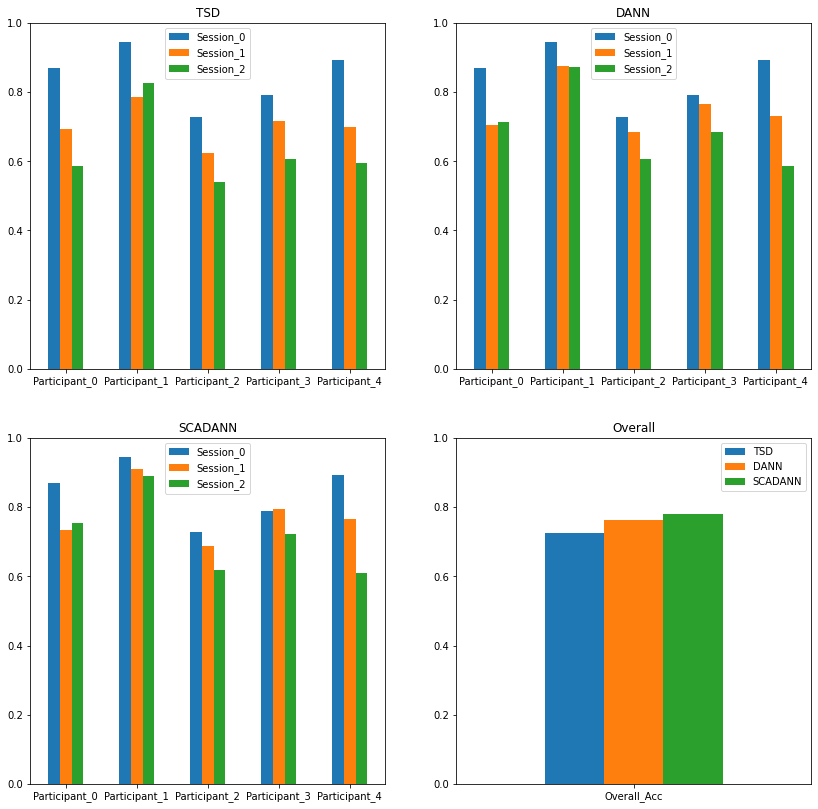

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
acc_list = [TSD_df, DANN_df, SCADANN_df, overall_acc_df]
title_list = ["TSD", "DANN", "SCADANN", "Overall"]
for idx, ax in enumerate(axes.reshape(-1)): 
    acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
    ax.set_title(title_list[idx])
    ax.set_ylim([0, 1.0])